Optimal Sector Rotation Model Metrics:
Total Return: 149.59%
Sharpe Ratio: 0.70


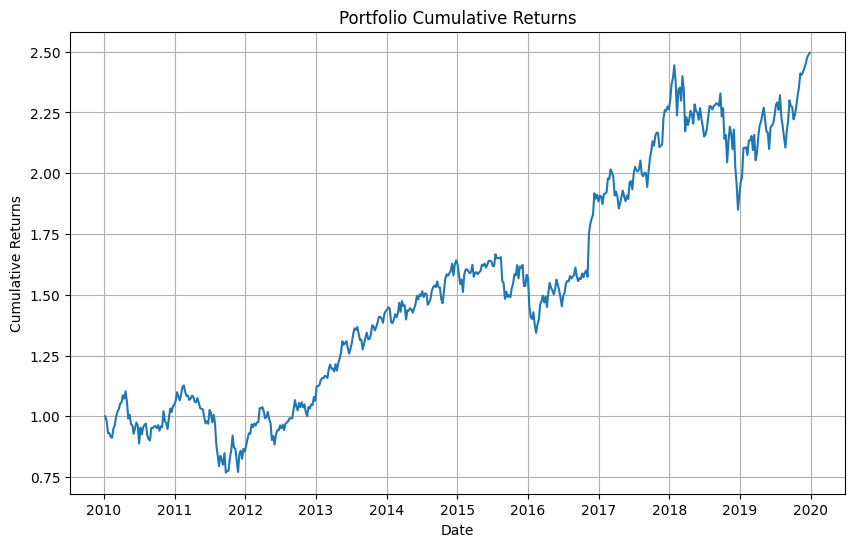

In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Step 1: Data Import from Excel
excel_file = '/content/10SectorsExcludeRESPXLBU.xlsx'  # Provide the path to your Excel file
df = pd.read_excel(excel_file, index_col=0)  # Assuming the first column contains dates

# Step 2: Calculate Returns
sector_returns = df.pct_change()

# Step 3: Identify Strength
short_window = 50
long_window = 200
short_mavg = df.rolling(window=short_window, min_periods=1).mean()
long_mavg = df.rolling(window=long_window, min_periods=1).mean()

# Step 4: Rotation Strategy
signals = np.where(short_mavg > long_mavg, 1.0, 0.0)
signals = np.where((short_mavg < long_mavg) & (signals != 1.0), -1.0, signals)

# Function to calculate Sharpe ratio
def calculate_sharpe_ratio(weights, returns, risk_free_rate):
    portfolio_return = returns.mean().dot(weights)
    excess_return = portfolio_return - risk_free_rate
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(returns.cov(), weights)))
    sharpe_ratio = excess_return / portfolio_std
    return -sharpe_ratio  # Maximize Sharpe ratio

# Optimization function
def optimize_portfolio(initial_weights, returns):
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Sum of weights equals 1
    bounds = tuple((0, 1) for _ in range(len(initial_weights)))  # Bounds for weights (0 <= weight <= 1)

    # Wrapper function to pass additional parameters to the objective function
    objective_function = lambda weights, returns=returns: calculate_sharpe_ratio(weights, returns, risk_free_rate=0.02)

    result = minimize(objective_function, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

num_assets = len(sector_returns.columns)
initial_weights = np.array([1 / num_assets] * num_assets)
optimized_allocation = optimize_portfolio(initial_weights, sector_returns)

# Calculate cumulative returns
portfolio_returns = np.dot(sector_returns.fillna(0).values, optimized_allocation)
cumulative_returns = (portfolio_returns + 1).cumprod()

# Print metrics
total_return = cumulative_returns[-1] - 1
sharpe_ratio = calculate_sharpe_ratio(optimized_allocation, sector_returns, risk_free_rate=0.02)

print("Optimal Sector Rotation Model Metrics:")
print(f"Total Return: {total_return:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(df.index, cumulative_returns)
plt.title('Portfolio Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.grid(True)
plt.show()

